<a href="https://colab.research.google.com/github/IgnacioPardo/TDIV/blob/main/Bellman_Ford.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [116]:
import threading
from typing import Type, Dict, List, Any
import sys

import networkx as nx
import matplotlib.pyplot as plt
from copy import deepcopy

In [117]:
# Si se decide usar float('inf') o alguna otra forma de decir que un nodo no tiene link con otro se puede cambiar lo que evalua inf()
inf = lambda : sys.maxsize
inf()

9223372036854775807

# Bellman-Ford algorithm

## Node behaviour


In [123]:
class Node:
    '''
        Bellman-Ford algorithm node implementation
    '''

    _t : int = 0
    _id : int
    _neighbours : Dict[Any, int]
    _direct_neighbours : List[Any] = []
    weights : Dict[Any, int]
    _G = None

    def __init__(self, node_id : int):
        '''
            Constructor
            pre: node_id is an integer
            post: a new node is created
        '''

        self._id = node_id
        self._neighbours = {
           self: 0
        }
        self.weights = {}
        self._G = nx.DiGraph()

    def set_initial_costs(self,
            initial_neighbours:  Dict[Any, int]):
        '''
            pre: initial_neighbours is a dictionary of nodes and costs
            post: the initial costs are set    
        '''
        #print(self)
        #print(self.get_id())
        #print(self.weights)
        for n in initial_neighbours:
            if initial_neighbours[n] is not inf():
                self._direct_neighbours.append(n)
                self._G.add_edge(self.get_id(), n.get_id(), weight=initial_neighbours[n])
                self.weights[(self.get_id(), n.get_id())] = deepcopy(initial_neighbours[n])
                #print("not inf: ", self.get_id(), n.get_id(), initial_neighbours[n])
            #else:
              #print("inf: ", self.get_id(), n.get_id(), initial_neighbours[n])

            #print(self.get_id(), n.get_id(), initial_neighbours[n])

            self._neighbours[n] = deepcopy(initial_neighbours[n])
          
        #print(a.weights)
        #print(self)

    def update_list(self, neighbour_node: Any):
        '''
            pre: neighbour_node is a node
            post: the list of neighbours is updated
        '''

        self._neighbours[neighbour_node] = neighbour_node.get_cost(self) + neighbour_node.get_cost(neighbour_node)

        for n in neighbour_node.get_neighbours():
            self._neighbours[n] = min([self.get_cost(neighbour_node) + neighbour_node.get_cost(n), self.get_cost(n)])
            if n in self._direct_neighbours:
              self._G.add_edge(self.get_id(), n.get_id(), weight=self.get_cost(n))
              self.weights[(self._id, n.get_id())] = self.get_cost(n)
        self._t += 1

    def update_direct_neighbours(self):
        '''
            post: each direct neighbour is updated
        '''
        for n in self._direct_neighbours:
            n.update_list(self)

    def get_neighbours(self) -> List[Any]:
        '''
            post: the list of neighbour nodes is returned
        '''
        #return list(self._neighbours.keys())
        for n in self._neighbours:
            yield n

    def get_cost(self, neighbour_node: Any) -> int:
        '''
            pre: neighbour_node is a node
            post: the cost to the neighbour node is returned
        '''
        return self._neighbours[neighbour_node]

    def get_id(self) -> int:
        '''
            post: the id of the node is returned
        '''

        return self._id
    
    def __eq__(self, other) -> bool:
        '''
            pre: other is a node
            post: the nodes are compared by id
        '''

        return self._id == other._id #and str(self) == str(other)
    
    def __hash__(self) -> int:
        '''
            post: the hash of the node is returned based on the id
        '''

        return hash(self._id)

    def get_time(self) -> int:
        '''
            post: the time of the node is returned
        '''

        return self._t

    def __str__(self) -> str:
        return str(self._id) + "(t_" + str(self.get_time()) + ") : " + str({str(n.get_id()) + " : " + str(self._neighbours[n]) for n in self._neighbours})
    
    def __repr__(self) -> str:
        return str(self._id) + "(t_" + str(self.get_time()) + ") : " + str({str(n.get_id()) + " : " + str(self._neighbours[n]) for n in self._neighbours})
    
    def draw(self, fig=None):
        '''
            post: the graph is drawn using networkx
        '''

        pos = {}
        x = 0
        y = 0
        for i, n in enumerate(self.get_neighbours()):
            pos[n.get_id()] = (x, y)
            if y == 1:
                y = 0
                x += 1
            else:
                y += 1

        options = {
            "font_size": 16,
            "node_size": 3000,
            "edgecolors": "black",
            "linewidths": 3,
            "width": 3,
            "connectionstyle": "arc3, rad=0",
            "node_color": "cyan",
        }

        #print(self.weights)
        #print(self._G.edges)
        #print(pos)
        pos = nx.circular_layout(self._G)
        nx.draw_networkx(self._G, pos, **options)
        nx.draw_networkx_edge_labels(
            self._G, pos,
            edge_labels=self.weights,
            font_color='black',
            font_size=16, 
            font_weight='bold'
        )
        ax = plt.gca()
        ax.margins(0.20)
        plt.axis('off')
        if fig:
          fig.suptitle(str(self.get_id()) + " (t_" + str(self.get_time()) + ")", fontsize=20)
        else:
          plt.title(str(self.get_id()) + " (t_" + str(self.get_time()) + ") min costs")


## Graph behaviour

In [124]:
class Graph:
    '''
        Graph implementation for the Bellman-Ford algorithm
    '''

    nodes : List[Any]
    weights = {}
    t = 0
    G = None

    def __init__(self, nodes: List[Type[Node]]):
        '''
            pre: nodes is a list of nodes
            post: a new graph is created
        '''

        self.nodes = nodes
        self.G = nx.Graph()

        for n in self.get_nodes():
            for m in n.get_neighbours():
                if n.get_cost(m) != inf():
                    self.G.add_edge(n.get_id(), m.get_id(), weight=n.get_cost(m))
                    self.weights[(n.get_id(), m.get_id())] = n.get_cost(m)

    def get_time(self) -> int:
        '''
            post: the time of the graph is returned
        '''
        return self.t

    def get_nodes(self) -> List[Type[Node]]:
        '''
            post: the list of nodes is returned
        '''
        
        return self.nodes
    
    def get_nodes_id(self) -> List[int]:
        '''
            post: the list of nodes id is returned 
        '''

        return [n.get_id() for n in self.nodes]

    def update_nodes(self, times = 1) -> int:
        '''
            post: each node is updated (a given ammount of times), the time is incremented and is returned    
        '''
        for i in range(times):
            for n in self.get_nodes():
                n.update_direct_neighbours()
        self.t += times
        return self.t

    def __str__(self) -> str:
        return str(self.nodes)
    
    def __repr__(self) -> str:
        return str(self.nodes)

    def __eq__(self, __o: object) -> bool:
        '''
            pre: __o is a graph, graph are compared node-wise
        '''

        return self.nodes == __o.nodes

    def __hash__(self) -> int:
        '''
            post: the hash of the graph is returned based on the nodes
        '''

        return hash(self.nodes)
    
    def draw(self):
        '''
            post: the graph is drawn using networkx, draws the graph at time t for each node
        '''

        fig = plt.figure(0)
        fig.suptitle("Graph (t_" + str(self.get_time()) + ")", fontsize=20)
        
        pos = {}
        x = 0
        y = 0
        for i, n in enumerate(self.get_nodes_id()):
            pos[n] = (x, y)
            if y == 1:
                y = 0
                x += 1
            else:
                y += 1

        options = {
            "font_size": 16,
            "node_size": 3000,
            "edgecolors": "black",
            "linewidths": 3,
            "width": 3,
            "connectionstyle": "arc3, rad=0",
            "node_color": "cyan",
        }
        pos = nx.circular_layout(self.G)
        nx.draw_networkx(self.G, pos, **options)
        nx.draw_networkx_edge_labels(
            self.G, pos,
            edge_labels=self.weights,
            font_color='black',
            font_size=16, 
            font_weight='bold'
        )

        ax = plt.gca()
        ax.margins(0.20)
        plt.axis('off')

        for i, n in enumerate(self.get_nodes()):
            fig = plt.figure(i+1)
            n.draw(fig)
            #fig.suptitle(str(n.get_id()) + " (t_" + str(n.get_time()) + ")", fontsize=20)

In [125]:
a = Node(1)
b = Node(2)
c = Node(3)
d = Node(4)
e = Node(5)

a.set_initial_costs({b: 1, c: 2, d: 5, e: inf()})
b.set_initial_costs({a: 1, c: inf(), d: inf(), e: 3})
c.set_initial_costs({a: 2, b: inf(), d: 1, e: inf()})
d.set_initial_costs({a: 5, b: inf(), c: 1, e: 1})
e.set_initial_costs({a: inf(), b: 3, c: inf(), d: 1})

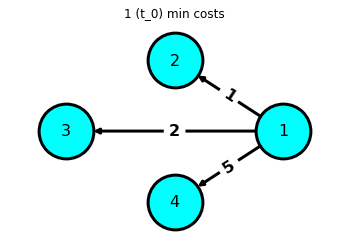

In [126]:
a.draw()

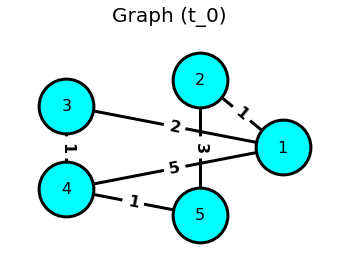

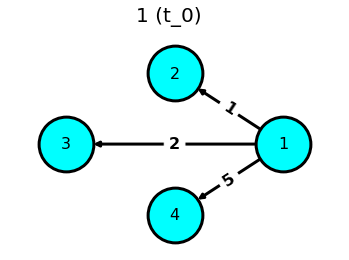

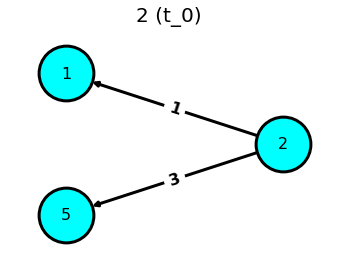

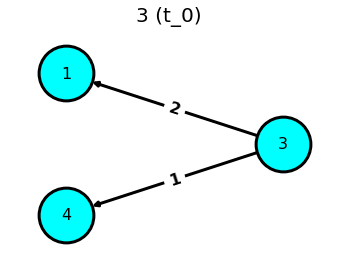

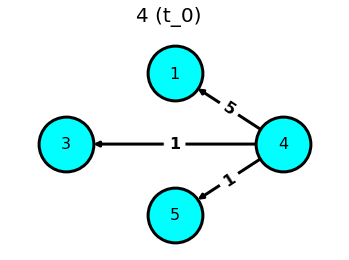

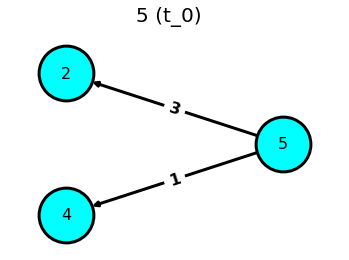

In [127]:
graph = Graph([a, b, c, d, e])
graph.draw()

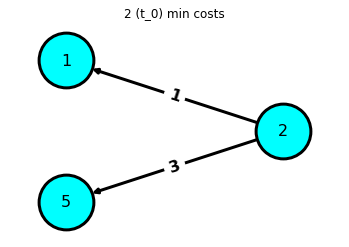

In [128]:
b.draw()

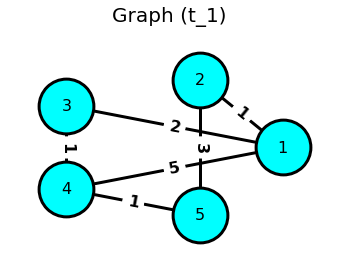

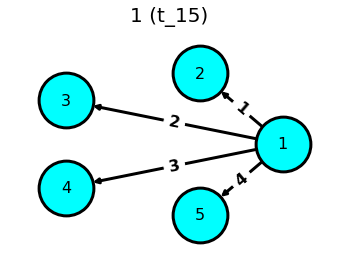

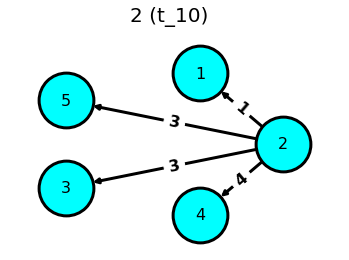

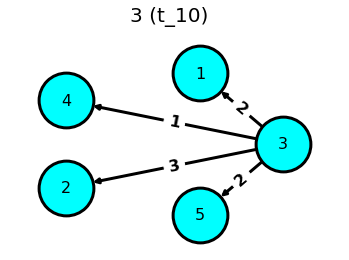

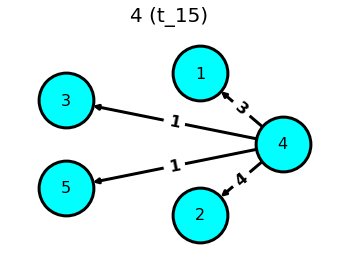

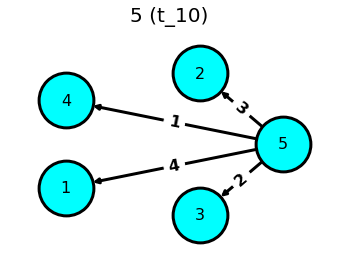

In [129]:
graph.update_nodes()
graph.draw()

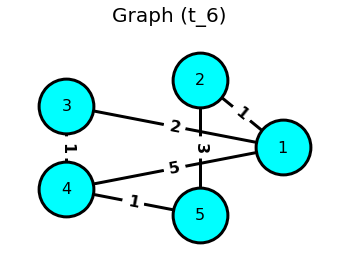

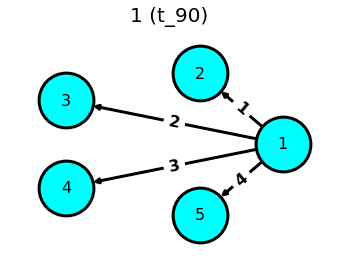

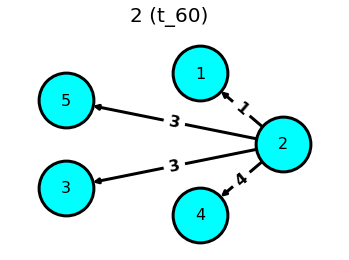

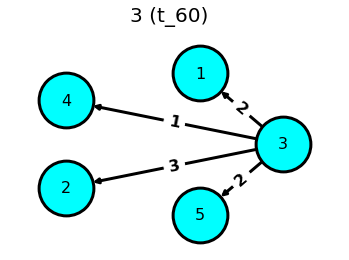

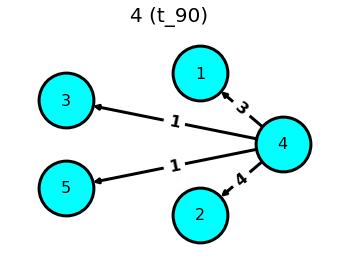

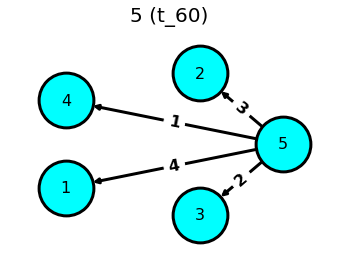

In [130]:
graph.update_nodes(5)
graph.draw()